In [154]:
import yfinance as yf
import pandas as pd
import numpy as np

In [155]:
ticker = "eqnr.OL"
start = "2000-01-01"
end = None

In [156]:
df = yf.download(ticker, start=start, end=end, auto_adjust=False, progress=False)

if df.empty:
    raise ValueError(f"Ingen data for {ticker} i perioden.")
    
px = df["Adj Close"].dropna() #.rename(columns={"Adj Close":"price"})
px.columns = ["price"]
px = px.reset_index()
px

,Date,price
0,2000-01-03,22.426344
1,2000-01-04,22.068306
2,2000-01-05,21.612619
3,2000-01-06,22.393791
4,2000-01-07,22.751833
...,...,...
6606,2026-01-21,253.300003
6607,2026-01-22,243.000000
6608,2026-01-23,249.699997
6609,2026-01-26,249.000000


In [157]:


px["ma50"]  = px["price"].rolling(window=50,  min_periods=1).mean()
px["ma100"] = px["price"].rolling(window=100, min_periods=1).mean()
px["ma200"] = px["price"].rolling(window=200, min_periods=1).mean()
px

,Date,price,ma50,ma100,ma200
0,2000-01-03,22.426344,22.426344,22.426344,22.426344
1,2000-01-04,22.068306,22.247325,22.247325,22.247325
2,2000-01-05,21.612619,22.035756,22.035756,22.035756
3,2000-01-06,22.393791,22.125265,22.125265,22.125265
4,2000-01-07,22.751833,22.250579,22.250579,22.250579
...,...,...,...,...,...
6606,2026-01-21,253.300003,237.755507,238.860452,242.018524
6607,2026-01-22,243.000000,237.792369,238.888730,241.910537
6608,2026-01-23,249.699997,237.943537,238.945604,241.903584
6609,2026-01-26,249.000000,238.169329,238.983662,241.942767


In [158]:
px["score"] = 1*(px["ma50"] > px["ma100"] 
                 )+ 1*( px["ma50"] > px["ma200"] 
                       ) + 1*( px["ma100"] > px["ma200"] )

px

,Date,price,ma50,ma100,ma200,score
0,2000-01-03,22.426344,22.426344,22.426344,22.426344,0
1,2000-01-04,22.068306,22.247325,22.247325,22.247325,0
2,2000-01-05,21.612619,22.035756,22.035756,22.035756,0
3,2000-01-06,22.393791,22.125265,22.125265,22.125265,0
4,2000-01-07,22.751833,22.250579,22.250579,22.250579,0
...,...,...,...,...,...,...
6606,2026-01-21,253.300003,237.755507,238.860452,242.018524,0
6607,2026-01-22,243.000000,237.792369,238.888730,241.910537,0
6608,2026-01-23,249.699997,237.943537,238.945604,241.903584,0
6609,2026-01-26,249.000000,238.169329,238.983662,241.942767,0


In [159]:
px["ret"] = px["price"].pct_change()
px

,Date,price,ma50,ma100,ma200,score,ret
0,2000-01-03,22.426344,22.426344,22.426344,22.426344,0,NaN
1,2000-01-04,22.068306,22.247325,22.247325,22.247325,0,-0.015965
2,2000-01-05,21.612619,22.035756,22.035756,22.035756,0,-0.020649
3,2000-01-06,22.393791,22.125265,22.125265,22.125265,0,0.036144
4,2000-01-07,22.751833,22.250579,22.250579,22.250579,0,0.015988
...,...,...,...,...,...,...,...
6606,2026-01-21,253.300003,237.755507,238.860452,242.018524,0,0.008761
6607,2026-01-22,243.000000,237.792369,238.888730,241.910537,0,-0.040663
6608,2026-01-23,249.699997,237.943537,238.945604,241.903584,0,0.027572
6609,2026-01-26,249.000000,238.169329,238.983662,241.942767,0,-0.002803


In [160]:
k = 1  # be in when score is 2 or 3
px["signal_raw"] = (px["score"] >= k).astype(int)


In [161]:
# px has columns: ret (stock daily returns), signal_raw (0/1 computed on day t)
px["pos"] = px["signal_raw"].shift(1).fillna(0)  # trade at t+1

rf_annual = 0.03  # 3% per year
rf_daily  = (1 + rf_annual)**(1/252) - 1    # start here; later replace with real rf series

px["strat_ret"] = px["pos"] * px["ret"] + (1 - px["pos"]) * rf_daily
px["strat_equity"] = (1 + px["strat_ret"]).cumprod()
px["hold_equity"] = (1 + px["ret"]).cumprod()

In [162]:
px

,Date,price,ma50,ma100,ma200,score,ret,signal_raw,pos,strat_ret,strat_equity,hold_equity
0,2000-01-03,22.426344,22.426344,22.426344,22.426344,0,NaN,0,0.0,NaN,NaN,NaN
1,2000-01-04,22.068306,22.247325,22.247325,22.247325,0,-0.015965,0,0.0,0.000117,1.000117,0.984035
2,2000-01-05,21.612619,22.035756,22.035756,22.035756,0,-0.020649,0,0.0,0.000117,1.000235,0.963716
3,2000-01-06,22.393791,22.125265,22.125265,22.125265,0,0.036144,0,0.0,0.000117,1.000352,0.998548
4,2000-01-07,22.751833,22.250579,22.250579,22.250579,0,0.015988,0,0.0,0.000117,1.000469,1.014514
...,...,...,...,...,...,...,...,...,...,...,...,...
6606,2026-01-21,253.300003,237.755507,238.860452,242.018524,0,0.008761,0,0.0,0.000117,4.156315,11.294752
6607,2026-01-22,243.000000,237.792369,238.888730,241.910537,0,-0.040663,0,0.0,0.000117,4.156802,10.835471
6608,2026-01-23,249.699997,237.943537,238.945604,241.903584,0,0.027572,0,0.0,0.000117,4.157290,11.134227
6609,2026-01-26,249.000000,238.169329,238.983662,241.942767,0,-0.002803,0,0.0,0.000117,4.157777,11.103014


In [ ]:
ratio = px["strat_equity"].iloc[-1] / px["hold_equity"].iloc[-1]

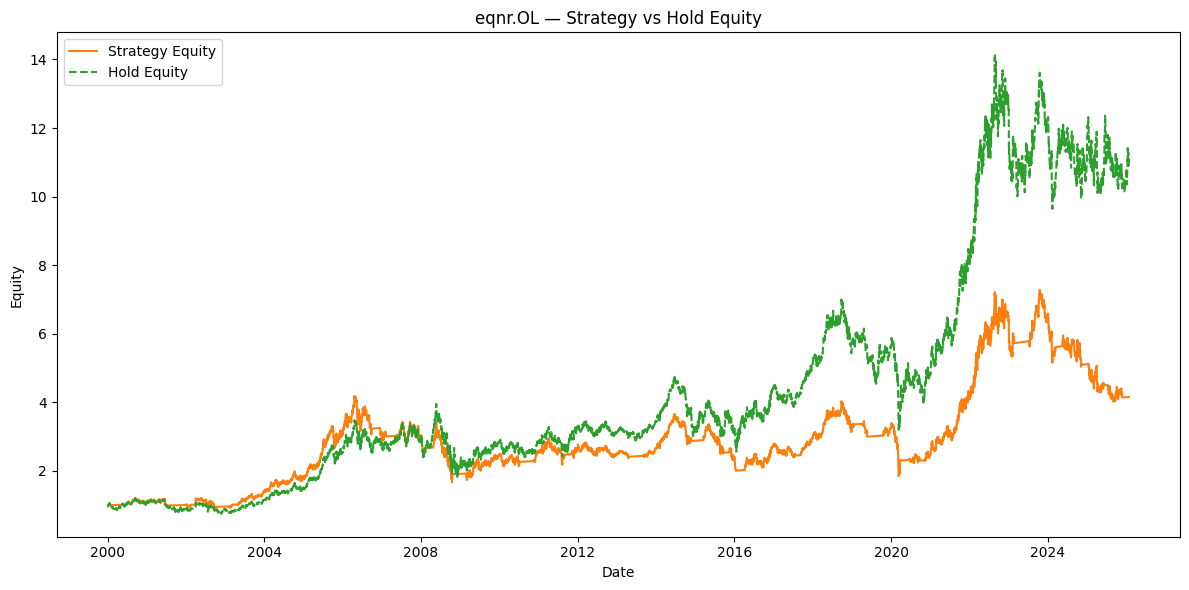

In [163]:
import matplotlib.pyplot as plt

# x is the date column (first column after reset_index)
x = px.iloc[:, 0]
plt.figure(figsize=(12, 6))
plt.plot(x, px['strat_equity'], label='Strategy Equity', color='tab:orange')
plt.plot(x, px['hold_equity'], label='Hold Equity', color='tab:green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title(f'{ticker} — Strategy vs Hold Equity')
plt.legend()
plt.tight_layout()
plt.show()